## Load and transform data

Данные брались с сайта http://recsys.deib.polimi.it/datasets/

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output

from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
for dirname, _, filenames in os.walk("ThirtyMusic"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ThirtyMusic/relations/sessions.idomaar
ThirtyMusic/relations/love.idomaar
ThirtyMusic/relations/events.idomaar
ThirtyMusic/entities/playlist.idomaar
ThirtyMusic/entities/users.idomaar
ThirtyMusic/entities/tracks.idomaar
ThirtyMusic/entities/albums.idomaar
ThirtyMusic/entities/tags.idomaar
ThirtyMusic/entities/persons.idomaar


In [5]:
colnames = ["type", "ID", "timestamp", "properties", "linked-entities"]
persons_df = pd.read_csv(
    "ThirtyMusic/entities/persons.idomaar", sep="\t", header=None, names=colnames
)
persons_df.head()

,type,ID,timestamp,properties,linked-entities
0,person,145148,-1,"{""MBID"":null, ""name"":""Everything+Is+Illuminated""}",{}
1,person,297899,-1,"{""MBID"":null, ""name"":""Robin+O%27Brien""}",{}
2,person,250429,-1,"{""MBID"":null, ""name"":""Nicholas+Gunn++(2012)""}",{}
3,person,32765,-1,"{""MBID"":null, ""name"":""Aspasia+Stratigou""}",{}
4,person,18689,-1,"{""MBID"":null, ""name"":""Allison+Veltz""}",{}


In [6]:
tracks_df = pd.read_csv(
    "ThirtyMusic/entities/tracks.idomaar", sep="\t",
    header=None, names=colnames
).drop_duplicates()
tracks_df.head()

,type,ID,timestamp,properties,linked-entities
0,track,0,-1,"{""duration"":-1,""playcount"":4,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":0}],""albums""..."
1,track,1,-1,"{""duration"":-1,""playcount"":495,""MBID"":null,""na...","{""artists"":[{""type"":""person"",""id"":1}],""albums""..."
2,track,2,-1,"{""duration"":-1,""playcount"":2,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":2}],""albums""..."
3,track,3,-1,"{""duration"":-1,""playcount"":2,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":3}],""albums""..."
4,track,4,-1,"{""duration"":-1,""playcount"":1,""MBID"":null,""name...","{""artists"":[{""type"":""person"",""id"":4}],""albums""..."


In [7]:
track_ids = tracks_df["ID"].values
artist_ids = []
for row in tqdm(tracks_df["linked-entities"]):
    artist_ids.append(json.loads(row)["artists"][0]["id"])

100%|██████████| 4544646/4544646 [00:14<00:00, 312285.42it/s]


In [8]:
track_artist_df = pd.DataFrame({"track_id": track_ids, "artist_id": artist_ids}).drop_duplicates()
track_artist_df.head()

,track_id,artist_id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


In [9]:
sessions_df = pd.read_csv(
    "ThirtyMusic/relations/sessions.idomaar", sep="\t", header=None,
    names=["type", "ID", "timestamp", "properties", "linked-entities"]
)
sessions_df.head()

,type,ID,timestamp,properties,linked-entities
0,event.session,287144,1390231051,"{""numtracks"":23,""playtime"":4547} {""subjects"":[...",NaN
1,event.session,287145,1390241844,"{""numtracks"":11,""playtime"":2907} {""subjects"":[...",NaN
2,event.session,287146,1390303249,"{""numtracks"":16,""playtime"":3191} {""subjects"":[...",NaN
3,event.session,287147,1390481828,"{""numtracks"":5,""playtime"":1162} {""subjects"":[{...",NaN
4,event.session,287140,1421443687,"{""numtracks"":2,""playtime"":250} {""subjects"":[{""...",NaN


In [10]:
user_session_df = defaultdict(list)
user_ids = []
track_ids = []
timestamps = []
for row, timestamp in tqdm(zip(sessions_df["properties"], sessions_df["timestamp"])):
    user_id = json.loads(row.split(" ")[1])["subjects"][0]["id"]
    for record in json.loads(row.split(" ")[1])["objects"][:-1]:
        user_ids.append(user_id)
        track_ids.append(record["id"])
        timestamps.append(timestamp + record["playstart"])

2764474it [01:40, 27495.58it/s]


In [11]:
user_track_history = pd.DataFrame({
    "user_id": user_ids,
    "track_id": track_ids,
    "timestamp": timestamps
})

In [12]:
user_artist_history = user_track_history \
    .merge(track_artist_df.set_index("track_id"), how="left", on="track_id") \
    .drop("track_id", axis=1)

user_artist_history["target"] = [1 for _ in range(len(user_artist_history))]

In [13]:
user_artist_history.head()

,user_id,timestamp,artist_id,target
0,44361,1390231051,142266,1
1,44361,1390231109,107103,1
2,44361,1390231419,324333,1
3,44361,1390231598,344448,1
4,44361,1390231940,309348,1


Упростим задачу и оставим только 2000 уникальных user_id

In [14]:
user_ids = set(user_artist_history.groupby("user_id") \
                .count().sort_values("artist_id", ascending=False) \
                .head(2000).index)


In [15]:
user_artist_history = user_artist_history[user_artist_history["user_id"].isin(user_ids)]

In [16]:
user_artist_history["user_id"] = user_artist_history["user_id"].map({
    artist_id: new_id
    for new_id, artist_id in enumerate(user_artist_history["user_id"].unique())
})

Разобьем на train/val/test как 70/15/15 по таймстемпу

In [18]:
val_split_timestamp = int(np.percentile(user_artist_history["timestamp"].values, 70))
test_split_timestamp = int(np.percentile(user_artist_history["timestamp"].values, 85))

In [19]:
train_dataset = user_artist_history[user_artist_history["timestamp"] <= val_split_timestamp].copy()
val_dataset = user_artist_history[(user_artist_history["timestamp"] > val_split_timestamp) & \
                                  (user_artist_history["timestamp"] <= test_split_timestamp)].copy()
test_dataset = user_artist_history[user_artist_history["timestamp"] > test_split_timestamp].copy()

train_dataset.drop("timestamp", axis=1, inplace=True)
val_dataset.drop("timestamp", axis=1, inplace=True)
test_dataset.drop("timestamp", axis=1, inplace=True)

In [20]:
train_dataset.drop_duplicates(inplace=True)
val_dataset.drop_duplicates(inplace=True)
test_dataset.drop_duplicates(inplace=True)

train_dataset.reset_index(drop=True, inplace=True)
val_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

## Negative sampling

Количество негативных примеров поставил примерно в пять раз меньше чем позитивных

In [22]:
NUM_NEGATIVES = 100

In [23]:
n_artists = user_artist_history["artist_id"].max() + 1
artists_popularity = np.zeros(n_artists)
popularity_power = 0.5  # -- sqrt of popularity sampling
# popularity_power = 0.0 -- uniform sampling
# popularity_power = 1.0 -- by popularity sampling


for row in user_artist_history.groupby("artist_id").count().itertuples():
    artists_popularity[row.Index] = row.user_id
artists_popularity = artists_popularity**popularity_power

In [ ]:
unique_artists = set(user_artist_history["artist_id"].unique())
negative_user_ids = []
negative_atrist_ids = []
for user_id, df in tqdm(train_dataset.groupby("user_id")):
    possible_artist_ids = unique_artists.difference(set(df["artist_id"]))
    possible_artists_popularity = np.array([artists_popularity[artist_id] for artist_id in possible_artist_ids])
    possible_artists_popularity /= sum(possible_artists_popularity)
    for negative_artist_id in np.random.choice(
        list(possible_artist_ids), p=possible_artists_popularity,
        size=NUM_NEGATIVES, replace=False):
        negative_user_ids.append(user_id)
        negative_atrist_ids.append(negative_artist_id)

negatives_df = pd.DataFrame({"user_id": negative_user_ids, "artist_id": negative_atrist_ids})
negatives_df["target"] = [0 for _ in range(len(negatives_df))]
train_dataset = pd.concat((train_dataset, negatives_df))

  0%|          | 32/38570 [00:13<4:16:59,  2.50it/s]

In [26]:
unique_artists = set(user_artist_history["artist_id"].unique())
negative_user_ids = []
negative_atrist_ids = []
for user_id, df in tqdm(val_dataset.groupby("user_id")):
    possible_artist_ids = unique_artists.difference(set(df["artist_id"]))
    possible_artists_popularity = np.array([artists_popularity[artist_id] for artist_id in possible_artist_ids])
    possible_artists_popularity /= sum(possible_artists_popularity)
    for negative_artist_id in np.random.choice(
        list(possible_artist_ids), p=possible_artists_popularity,
        size=NUM_NEGATIVES, replace=False):
        negative_user_ids.append(user_id)
        negative_atrist_ids.append(negative_artist_id)

negatives_df = pd.DataFrame({"user_id": negative_user_ids, "artist_id": negative_atrist_ids})
negatives_df["target"] = [0 for _ in range(len(negatives_df))]
val_dataset = pd.concat((val_dataset, negatives_df))

100%|██████████| 1767/1767 [08:42<00:00,  3.38it/s]


In [30]:
train_dataset.to_csv("train_dataset.csv", index=None)
val_dataset.to_csv("val_dataset.csv", index=None)
test_dataset.to_csv("test_dataset.csv", index=None)

## Baseline: top artists recommendation

Я выбрал целевой метрикой MAP@K с K = {10, 50, 100} так как она хорошо подходит для рекомендаций и ранжирования

#### MAP@10

In [8]:
def ap_at_k(relevant_ids, recommendation_artists, K):
    ap = 0
    cur_relevant = 0
    for k, recommendation_artist_id in enumerate(recommendation_artists):
        if recommendation_artist_id in relevant_ids:
            cur_relevant += 1
            ap += cur_relevant / (k + 1)

    ap /= K
    return ap

In [9]:
K = 10
recommendation_artists = list(user_artist_history.groupby("artist_id") \
    .count().sort_values("user_id", ascending=False) \
    .head(K).index)

map_ = []
for user_id, df in tqdm(test_dataset.groupby("user_id")):
    map_.append(ap_at_k(set(df["artist_id"].values), recommendation_artists, K))

print(f"MAP@{K} = {np.mean(map_)}")

100%|██████████| 1930/1930 [00:00<00:00, 6513.70it/s]

MAP@10 = 0.07647627271979604


In [10]:
K = 50
recommendation_artists = list(user_artist_history.groupby("artist_id") \
    .count().sort_values("user_id", ascending=False) \
    .head(K).index)

map_ = []
for user_id, df in tqdm(test_dataset.groupby("user_id")):
    map_.append(ap_at_k(set(df["artist_id"].values), recommendation_artists, K))

print(f"MAP@{K} = {np.mean(map_)}")

100%|██████████| 1930/1930 [00:00<00:00, 6511.54it/s]

MAP@50 = 0.03831183036354622


In [11]:
K = 100
recommendation_artists = list(user_artist_history.groupby("artist_id") \
    .count().sort_values("user_id", ascending=False) \
    .head(K).index)

map_ = []
for user_id, df in tqdm(test_dataset.groupby("user_id")):
    map_.append(ap_at_k(set(df["artist_id"].values), recommendation_artists, K))

print(f"MAP@{K} = {np.mean(map_)}")

100%|██████████| 1930/1930 [00:00<00:00, 6196.59it/s]

MAP@100 = 0.028177431434001764


In [7]:
train_dataset = pd.read_csv("train_dataset.csv")
val_dataset = pd.read_csv("val_dataset.csv")
test_dataset = pd.read_csv("test_dataset.csv")
user_artist_history = pd.read_csv("user_artist_history.csv")

## Embedding model

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
N_EPOCHS = 10
VAL_ITERS = 20
BATCH_SIZE = 8049
EMBEDDING_DIM = 256

In [34]:
class EmbeddingModel(nn.Module):
    def __init__(self, n_users, n_artists, embedding_dim=256):
        super(EmbeddingModel, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.artist_embedding = nn.Embedding(n_artists, embedding_dim)
        
    def forward(self, users, artists):
        user_emb = self.artist_embedding(users)
        artist_emb = self.artist_embedding(artists)
        return user_emb, artist_emb

def get_val_loss(emb_model, val_dataloader, criterion, device):
    with torch.no_grad():
        losses = []
        for user_artist, target in tqdm(val_dataloader):
            users, artists = user_artist[:, 0], user_artist[:, 1]
            user_emb, artist_emb = emb_model(users.to(device), artists.to(device))
            losses.append(criterion(user_emb, artist_emb, target.to(device)).item())
        return np.mean(losses)

In [35]:
# train dataloader
user_artist_history_train_dataset = torch.tensor(train_dataset.loc[:, ["user_id", "artist_id"]].values).long()
user_artist_history_train_target = torch.tensor(train_dataset.loc[:, ["target"]].values).float()

user_artist_train_dataset = TensorDataset(user_artist_history_train_dataset, user_artist_history_train_target)
user_artist_train_dataloader = DataLoader(user_artist_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# val_dataset
user_artist_history_val_dataset = torch.tensor(val_dataset.loc[:, ["user_id", "artist_id"]].values).long()
user_artist_history_val_target = torch.tensor(val_dataset.loc[:, ["target"]].values).float()

user_artist_val_dataset = TensorDataset(user_artist_history_val_dataset, user_artist_history_val_target)
user_artist_val_dataloader = DataLoader(user_artist_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# test_dataset
user_artist_history_test_dataset = torch.tensor(test_dataset.loc[:, ["user_id", "artist_id"]].values).long()
user_artist_history_test_target = torch.tensor(test_dataset.loc[:, ["target"]].values).float()

user_artist_test_dataset = TensorDataset(user_artist_history_test_dataset, user_artist_history_test_target)
user_artist_test_dataloader = DataLoader(user_artist_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
n_users = user_artist_history["user_id"].max() + 1
n_artists = user_artist_history["artist_id"].max() + 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
emb_model = EmbeddingModel(n_users, n_artists, embedding_dim=EMBEDDING_DIM).to(device)

criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.RMSprop(emb_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCHS * len(user_artist_train_dataloader))

Тут я использую CosineAnnealingLR шедулер и оптимизатор RMSprop, так как они хорошо справляются с задачей

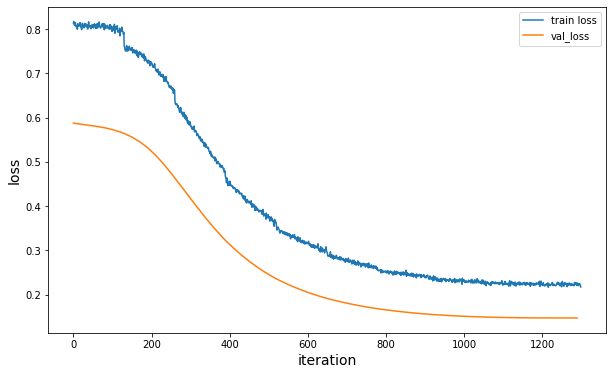

In [37]:
train_losses = []
val_losses = []

for epoch in range(N_EPOCHS):
    for iter_num, (user_artist, target) in enumerate(user_artist_train_dataloader):
        if iter_num % VAL_ITERS == 0:
                    
            val_losses.append((
                len(train_losses),
                get_val_loss(emb_model, user_artist_val_dataloader, criterion, device)))
            if len(val_losses) == 1 or val_losses[-1][1] < val_losses[-2][1]:
                torch.save(emb_model, "emb_model.pth")
                
        users, artists = user_artist[:, 0], user_artist[:, 1]
        user_emb, artist_emb = emb_model(users.to(device), artists.to(device))
        loss = criterion(user_emb, artist_emb, target.to(device))
        train_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        torch.cuda.empty_cache()
        
        clear_output(True)
        plt.figure(figsize=[10, 6])
        plt.plot(train_losses, label="train loss")
        plt.plot(*zip(*val_losses), label="val_loss")
        plt.xlabel("iteration", fontsize=14)
        plt.ylabel("loss", fontsize=14)
        plt.legend()
        plt.show()

### Eval embedding model

In [38]:
# Load best on validation model
emb_model = torch.load("emb_model.pth").to(device)

In [41]:
artist_embeddings = emb_model.artist_embedding.weight.data.numpy().copy()
user_embeddings = emb_model.user_embedding.weight.data.numpy().copy()

artist_embeddings /= np.sqrt(np.sum(artist_embeddings**2, axis=1, keepdims=True))
user_embeddings /= np.sqrt(np.sum(user_embeddings**2, axis=1, keepdims=True))

In [42]:
K = 10

map_ = []
for user_id, df in tqdm(val_dataset.groupby("user_id")):
    user_artist_distances = np.dot(artist_embeddings, user_embeddings[user_id])
    recommendation_artists = np.argsort(user_artist_distances)[::-1][:K]
    map_.append(ap_at_k(set(df["artist_id"].values), recommendation_artists, K))
    
print(f"MAP@{K} = {np.mean(map_)}")

100%|██████████| 1767/1767 [03:09<00:00,  9.31it/s]

MAP@10 = 3.8671948688926614e-05


In [43]:
K = 100

map_ = []
for user_id, df in tqdm(val_dataset.groupby("user_id")):
    user_artist_distances = np.dot(artist_embeddings, user_embeddings[user_id])
    recommendation_artists = np.argsort(user_artist_distances)[::-1][:K]
    map_.append(ap_at_k(set(df["artist_id"].values), recommendation_artists, K))
    
print(f"MAP@{K} = {np.mean(map_)}")

100%|██████████| 1767/1767 [03:12<00:00,  9.17it/s]

MAP@100 = 5.847047545373302e-06


### Some nearest neighbours

In [68]:
anchor_artists = [
    276125, 192147,  29427,  42398, 286091,  82955,  29145,  56683,
    134178, 345237, 195697, 228054, 299571, 415063, 124222, 246465,
    310487, 201108,  50474, 252583
]

for anchor_artist_id in anchor_artists:
    distances = np.dot(artist_embeddings, artist_embeddings[anchor_artist_id])
    for ind, artist_id in enumerate(np.argsort(distances)[::-1][:15]):
        try:
            name = json.loads(persons_df[persons_df["ID"] == artist_id]["properties"].values[0])["name"]
            name = name.replace('+', ' ').replace("%27", "\'")
            if ind == 0:
                print(f"Neighbours of {name}:")
                print("-"*10)
            else:
                print(f"{ind}) {name}")
        except:
            pass
        
    print("\n")

Neighbours of Pink Floyd & Floyd:
----------
1) Led Zepplin
2) The Doors
3) Jimmy Hendrix
4) Rolling Stones
5) Johnny Cash & June Carter Cash
6) The Beatles & George Martin
7) Bowie
8) Nirvana-in utero
9) R.E.M.
10) Dave Grohl%2FQueens of the Stone Age
11) The Who & David Gilmour
12) Bob Dylan & Tom Petty
13) Creedence Clearwater Revival
14) The Cure & the Cause (Acoustic Version)


Neighbours of Lana Del Rey:
----------
1) Coldplay & Kylie Minogue
2) Lorde & Katy Perry
3) Foster the People
4) Florence %252B the Machine
5) Sia & Beck
6) The Killers Feat. Elton John & Neil Tennant
7) Arctic Monekys
8) Kings of Leon
9) lykkeli
10) Daft Punk & Sander Kleinenberg
11) La Roux
12) Of Monsters and Men
13) Gotye
14) Capital Cities


Neighbours of Arctic Monekys:
----------
1) Kings of Leon
2) Franz Ferdinand & Jane Birkin
3) Yeah Yeah Yeahs
4) The Killers Feat. Elton John & Neil Tennant
5) Coldplay & Kylie Minogue
6) The Kooks
7) Of Monsters and Men
8) Oasis
9) MGMT
10) Lana Del Rey
11) The Bl

## Saving to tensorboard

Полученные эмбеддинги можно экспортировать в tensorboard и удобно просматривать

In [73]:
import tensorflow as tf
from tensorboard.plugins import projector

In [140]:
artist_ids = list(user_artist_history.groupby("artist_id") \
                  .count().sort_values("user_id", ascending=False) \
                  .head(1000).index)

In [141]:
cur_persons_df = persons_df.set_index('ID').loc[artist_ids].reset_index().groupby("ID").head(1)
person_names = [json.loads(row)["name"].replace("+", " ").replace("%27", "\'") for row in cur_persons_df["properties"]]


In [142]:
log_dir = "./logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
with open(os.path.join(log_dir, "metadata.tsv"), "w") as f:
    for name in person_names:
        f.write(f"{name}\n")

In [143]:
weights = tf.Variable(artist_embeddings[artist_ids])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'./logs/embedding.ckpt-1'

In [144]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = "metadata.tsv"
projector.visualize_embeddings(log_dir, config)

## Выводы и TODO

Эмбеддинги, кажется выглядят неплохо, но метрики ранжирования только по близости вектора пользователя и айтема не побеждают простой бейзлайн. Также обнаружил что в persons_df почему то нет российских исполнителей. И возможно эмбеддинги для пользователей получились неправильные, но я не успел это отдебажить.

Я не успел попробовать добавить дополнительных данных из датасета, например в сессиях можно было бы использовать playtime и делать из коротких взаимодействий негативы/убирать как невалидные. Так же не использовал статические фичи

А также неплохо было бы сделать отдельную ранжирующую модель для оптимизации целевой метрики